In [2]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import time

# Face recognition

## Read Data - Preprocessing

Define the **DATA_PATH** variable which is the location where the dataset faces is located

In [3]:
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/ML/project_2/faces"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set_1: person*_01.png to person*_07.png (the first 7 images of each face)\
Set_2: person*_08.png to person*_19.png\
Set_3: person*_20.png to person*_31.png\
Set_4: person*_32.png to person*_45.png\
Set_5: person*_46.png to person*_64.png

In [4]:
#path: the path where the images are located, 
#set_number: 'Set_x' where x indicates the n-th set
def loadImages(path, set_number):
  dir_list = os.listdir(DATA_PATH)
  set_number = int(set_number[-1])
  if set_number == 1:
    img_range = range(1,8)
  elif set_number == 2:
    img_range = range(8,20)
  elif set_number == 3:
    img_range = range(20,32)
  elif set_number == 4:
    img_range = range(32,46)
  else:
    img_range = range(46,65)

  img_set=[]
  labels = []
  for img in dir_list:
    no_of_img = int(img[9:11])
    no_of_person = int(img[6:8])
    if no_of_img in img_range:
      img_file = DATA_PATH + '/' + img
      im = Image.open(img_file, 'r')
      img_pix = list(im.getdata())
      img_set.append(np.array(img_pix))
      labels.append(no_of_person)
  
  return np.array(img_set), labels

In [5]:
def preprocess_img(img_set):
  mean = np.mean(img_set, axis=0)
  centered_img_set = img_set - mean 

  return centered_img_set

In [6]:
total_sets = 5
img_sets = []
init_img_sets = []
labels_sets = []
for i in range(1, total_sets+1):
  img_set_name = 'Set_' + str(i)
  img_set, label_set = loadImages(DATA_PATH, img_set_name)
  init_img_sets.append(img_set)
  img_set = preprocess_img(img_set)
  img_sets.append(img_set)
  labels_sets.append(label_set)

In [7]:
print(f'Total image sets: {len(img_sets)}')
print(f'Set 1 shape: {img_sets[0].shape}')
print(f'Image 1 of set 1 shape: {img_sets[0][0].shape}')

Total image sets: 5
Set 1 shape: (70, 2500)
Image 1 of set 1 shape: (2500,)


## Reduce dimensions with PCA

In [8]:
pca_9 = PCA(n_components=9)
pca_30 = PCA(n_components=30)
print ("Set 1.shape ",img_sets[0].shape)
train_comp_9 = pca_9.fit_transform(img_sets[0])
train_comp_30 = pca_30.fit_transform(img_sets[0])
print ("Train components (9).shape",train_comp_9.shape)
print ("Train components (30).shape",train_comp_30.shape)

Set 1.shape  (70, 2500)
Train components (9).shape (70, 9)
Train components (30).shape (70, 30)


In [9]:
test_comps_9 = []
test_comps_30 = []
for i, img_set in enumerate(img_sets):
  test_comp_9 = pca_9.transform(img_set)
  test_comp_30 = pca_30.transform(img_set)
  print (f'Test components set {i} (9).shape {test_comp_9.shape}')
  print (f'Test components set {i} (30).shape {test_comp_30.shape}')

  test_comps_9.append(test_comp_9)
  test_comps_30.append(test_comp_30)

Test components set 0 (9).shape (70, 9)
Test components set 0 (30).shape (70, 30)
Test components set 1 (9).shape (120, 9)
Test components set 1 (30).shape (120, 30)
Test components set 2 (9).shape (120, 9)
Test components set 2 (30).shape (120, 30)
Test components set 3 (9).shape (140, 9)
Test components set 3 (30).shape (140, 30)
Test components set 4 (9).shape (190, 9)
Test components set 4 (30).shape (190, 30)


## KNN Classification

Grid search to find optimal number of neighbors in KNN

In [10]:
param_grid = {'n_neighbors': range(1, 40)}  

knn_9 = KNeighborsClassifier()
best_knn_9 = GridSearchCV(knn_9, param_grid, cv=5)  
best_knn_9.fit(train_comp_9, labels_sets[0])

knn_30 = KNeighborsClassifier()
best_knn_30 = GridSearchCV(knn_30, param_grid, cv=5)  
best_knn_30.fit(train_comp_30, labels_sets[0])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40)})

In [11]:
accs_9 = []
accs_30 = []
for test_comp_9, test_comp_30, label_set in zip(test_comps_9, test_comps_30, labels_sets):
  cur_pred_9 = best_knn_9.predict(test_comp_9)
  cur_acc_9 = accuracy_score(label_set, cur_pred_9)
  accs_9.append(cur_acc_9)

  cur_pred_30 = best_knn_30.predict(test_comp_30)
  cur_acc_30 = accuracy_score(label_set, cur_pred_30)
  accs_30.append(cur_acc_30)

In [12]:
col_names = ['Components', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5']
preds = [[9] + accs_9, [30] + accs_30]
print(tabulate(preds, headers=col_names, tablefmt='fancy_grid'))

╒══════════════╤═════════╤══════════╤══════════╤══════════╤══════════╕
│   Components │   Set 1 │    Set 2 │    Set 3 │    Set 4 │    Set 5 │
╞══════════════╪═════════╪══════════╪══════════╪══════════╪══════════╡
│            9 │       1 │ 0.933333 │ 0.733333 │ 0.378571 │ 0.163158 │
├──────────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│           30 │       1 │ 0.95     │ 0.808333 │ 0.321429 │ 0.136842 │
╘══════════════╧═════════╧══════════╧══════════╧══════════╧══════════╛


The observed accuracies and the decreasing trend shows that the model's generalizability to different sets is limited. It indicates a potential issue of overfitting, where the model is overly tailored to the training data and is not able to generalize well to unseen and more diverse images. To improve generalizability for the Eigenfaces method, we could increase the diversity of the training data

## Plotting the 9 top eigenvectors

Printing the explained_variance_ratio

In [13]:
explained_variance_ratio = pca_9.explained_variance_ratio_

for i, ratio in enumerate(explained_variance_ratio):
    print("Explained variance ratio for Eigenvector {}: {:.2%}".format(i + 1, ratio))

Explained variance ratio for Eigenvector 1: 44.87%
Explained variance ratio for Eigenvector 2: 13.36%
Explained variance ratio for Eigenvector 3: 9.13%
Explained variance ratio for Eigenvector 4: 6.58%
Explained variance ratio for Eigenvector 5: 4.77%
Explained variance ratio for Eigenvector 6: 4.44%
Explained variance ratio for Eigenvector 7: 3.12%
Explained variance ratio for Eigenvector 8: 2.58%
Explained variance ratio for Eigenvector 9: 2.02%


We plot the 9 top eigenvectors

Seen the plot of the top eigenvectors we observe that the first capture more general and prominent features, such as global shapes or edges, that are common across the images in the dataset, which is indicated by the explained variance ratio. The last images seem to obtain information about the angle of the light.

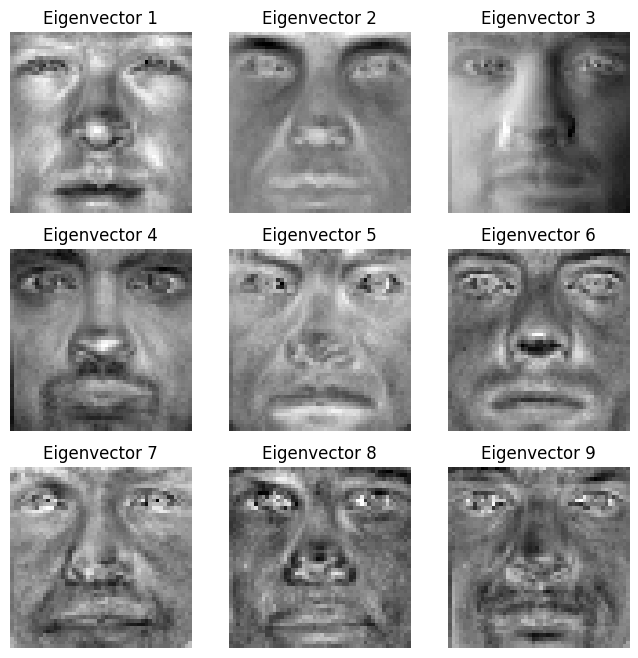

In [14]:
top_eigenvectors = pca_9.components_

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_eigenvectors[i].reshape((50, 50)), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenvector {i+1}')

plt.show()


## Plotting random original and reconstructed images

In [15]:
def plot_org_reconstr_imgs(org_imgs, reconstr_imgs, n_components):
  n_rows = len(org_imgs)
  fig, axes = plt.subplots(n_rows, 2, figsize=(8, 8))
  fig.suptitle('Original and Reconstructed Images - n_components: ' + str(n_components))
  for i in range(n_rows):
    axes[i, 0].imshow(org_imgs[i].reshape((50, 50)), cmap='gray')
    axes[i, 0].set_title('Original - Set ' + str(i+1))

    axes[i, 1].imshow(reconstr_imgs[i].reshape((50, 50)), cmap='gray')
    axes[i, 1].set_title('Reconstructed - Set ' + str(i+1))

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

In [20]:
def rand_imgs_reconstruction(init_img_sets, eigenfaces, components, n_components):
  rand_org_imgs = []
  rand_reconstr_imgs = []
  for init_img_set, comps in zip(init_img_sets, components):
    img_set_sz = init_img_set.shape[0]
    rand_img_idx = np.random.randint(low=0, high=img_set_sz)
    org_img = init_img_set[rand_img_idx]
    rand_org_imgs.append(org_img)

    weights = comps[rand_img_idx]
    reconstr_img = np.dot(weights, eigenfaces) + np.mean(init_img_set, axis=0)
    rand_reconstr_imgs.append(reconstr_img) 

  plot_org_reconstr_imgs(rand_org_imgs, rand_reconstr_imgs, n_components)

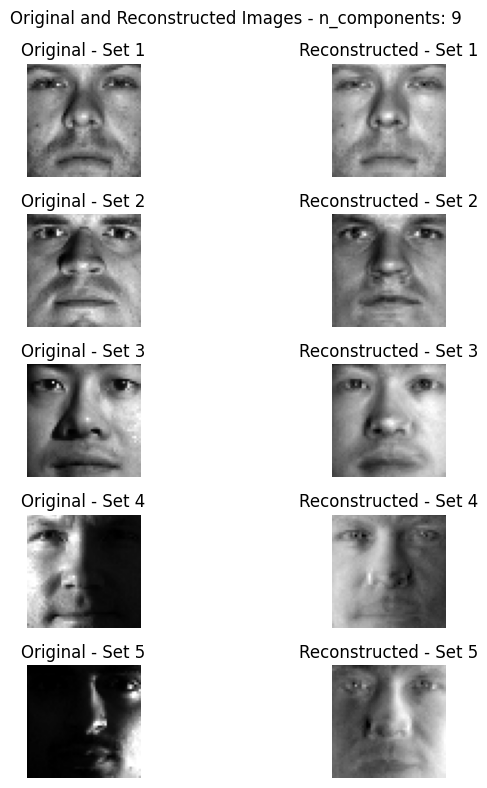

In [21]:
pca_9_mean = pca_9.mean_
eigenfaces = pca_9.components_
rand_imgs_reconstruction(init_img_sets, eigenfaces, test_comps_9,9)

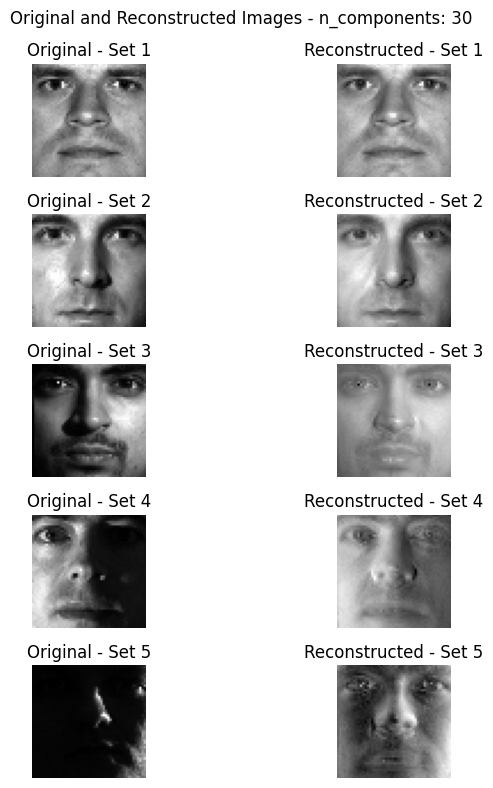

In [22]:
pca_30_mean = pca_30.mean_
eigenfaces = pca_30.components_
rand_imgs_reconstruction(init_img_sets, eigenfaces, test_comps_30,30)

Comparing the original with the reconstructed random images of each set we observe that there is a big similarity to the characteristics of the face. However there are many differences such as the image quality and the lighting angle of each image. From set 1 to set 5 the quality and reconstruction accuracy seem to decrease, which is indicated by the explained variance ratio. The information loss is bigger in the reconstruction with n_components = 9, than that with n_components = 30 where more details are maintained.   

## SVD

The first images seem to be related to the angle of the light of the face and the next ones to specific features such as eyes, nose and lips.

Top eigenvectors: 
[[ 0.01329749  0.01226758  0.01200115 ...  0.01156571  0.0109736
   0.00960218]
 [ 0.03658463  0.03534601  0.04161088 ... -0.00533421  0.00219448
  -0.00180202]
 [ 0.01750791  0.01206912  0.00811087 ... -0.03478369 -0.03718597
  -0.03922186]
 ...
 [ 0.05127077  0.04214608  0.05253477 ... -0.00023854  0.0238316
   0.03123576]
 [ 0.00487876 -0.01950633 -0.0372571  ... -0.00540651 -0.01573377
  -0.02284297]
 [-0.04175183 -0.04681319 -0.04275195 ...  0.00942748  0.02796531
   0.02862215]]
Top singular vectors:
 [[-0.01329749 -0.01226758 -0.01200115 ... -0.01156571 -0.0109736
  -0.00960218]
 [-0.03658463 -0.03534601 -0.04161088 ...  0.00533421 -0.00219448
   0.00180202]
 [ 0.01750791  0.01206912  0.00811086 ... -0.03478369 -0.03718597
  -0.03922186]
 ...
 [-0.05127075 -0.04214609 -0.05253474 ...  0.00023876 -0.02383142
  -0.03123564]
 [ 0.00487884 -0.0195063  -0.03725699 ... -0.00540638 -0.01573375
  -0.02284303]
 [ 0.04175217  0.04681341  0.0427523  ... -0.00942696 -0.02

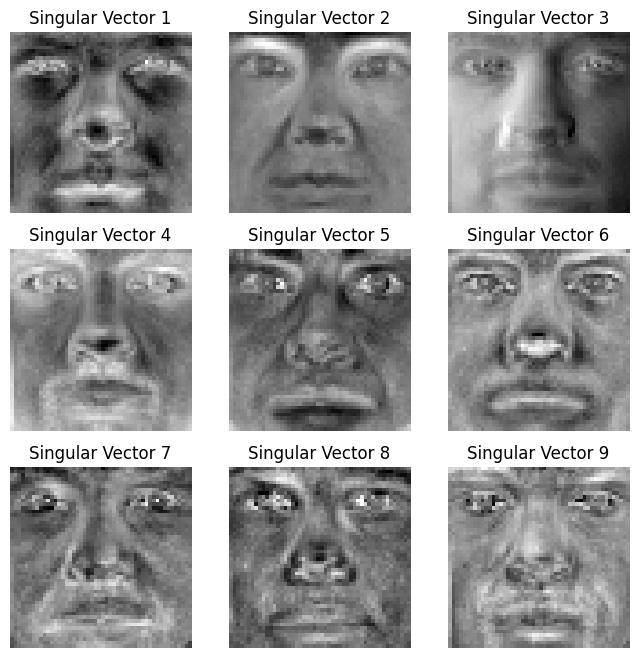

In [35]:
U, S, Vt = np.linalg.svd(img_sets[0])
top_singular_vectors = Vt[:9, :]
print(f'Top eigenvectors: \n{top_eigenvectors}')
print(f'Top singular vectors:\n {top_singular_vectors}')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_singular_vectors[i].reshape((50, 50)), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Singular Vector {i+1}')

plt.show()


While both singular vectors and eigenvectors are related to the principal components of a matrix, they are derived from different matrix factorizations and thus they have differnt values. PCA is primarily used for dimensionality reduction, where the top eigenvectors are chosen to form a reduced-dimensional subspace that captures most of the variance in the data. <br>The eigenvectors are ordered based on the magnitude of the corresponding eigenvalues, with the first eigenvector capturing the highest variance. In SVD, the top singular vectors also capture the most significant information in the matrix, but the emphasis is on representing the stretching and compression properties rather than dimensionality reduction. <br> The top eigenvector from PCA is derived from the covariance or correlation matrix of the input data, which is typically a square matrix. In contrast, the top singular vectors from SVD are derived from a rectangular matrix

# Classification of images using SVMs

## Read Data 

Read mnist dataset

In [2]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
print(f'train_X.shape: {train_X.shape}, train_Y.shape: {train_y.shape}')
print(f'test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}')

train_X.shape: (60000, 28, 28), train_Y.shape: (60000,)
test_X.shape: (10000, 28, 28), test_y.shape: (10000,)


Convert from 3D to 2D

In [4]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]*train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

In [5]:
print(f'train_X.shape: {train_X.shape}, train_Y.shape: {train_y.shape}')
print(f'test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}')

train_X.shape: (60000, 784), train_Y.shape: (60000,)
test_X.shape: (10000, 784), test_y.shape: (10000,)


Get distinct labels and their frequency in train dataset

In [6]:
labels, labels_freq = np.unique(train_y, return_counts=True)

for label, freq in zip(labels, labels_freq):
    print(f'Label {label}: {freq}')

Label 0: 5923
Label 1: 6742
Label 2: 5958
Label 3: 6131
Label 4: 5842
Label 5: 5421
Label 6: 5918
Label 7: 6265
Label 8: 5851
Label 9: 5949


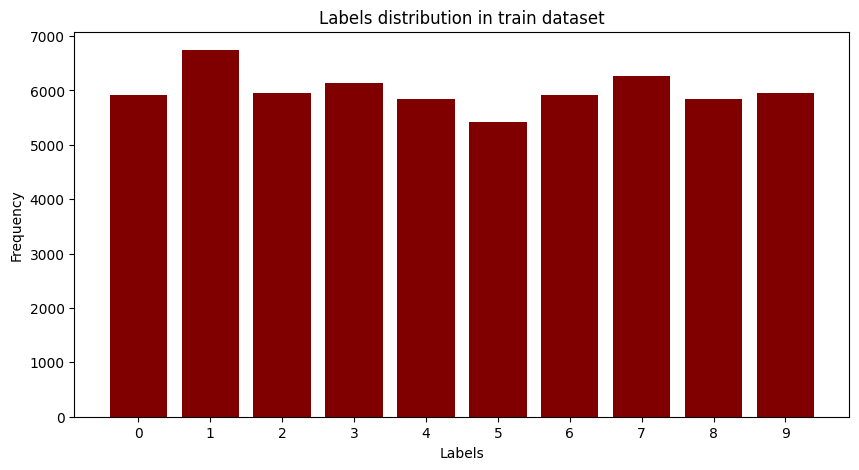

In [7]:
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, labels_freq, color ='maroon')#, width = 0.4)
plt.xticks(np.arange(min(labels), max(labels)+1, 1))

plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels distribution in train dataset")
plt.show()

We observe a balanced dristribution between the frequencies of each label

Normalization to [0,1] using MinMaxScaler

In [13]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

In [14]:
print(train_X[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Experimenting with hyperparameters

We use cross validation for more reliable performance estimation

SVM model with default parameters

In [15]:
SVM = svm.SVC()
start_time = time.time()
SVM.fit(train_X, train_y)
end_time = time.time()
fit_time = end_time - start_time
SVM_score = cross_validate(estimator=SVM, X=test_X, y=test_y, scoring='accuracy', n_jobs=-1)

In [16]:
fit_time_minutes = fit_time / 60
fit_time_minutes = "{:.2f}".format(fit_time_minutes)
accuracy = "{:.3f}".format(np.mean(SVM_score['test_score']*100))
print('SVM model with default parameters:')
print(f"   Fit Time: {fit_time_minutes} minutes")
print(f"   Accuracy: {accuracy}")

SVM model with default parameters:
   Fit Time: 7.42 minutes
   Accuracy: 95.820


Randomized search on hyper parameters. We experiment with: 
* **C**: [0.01, 0.1, 1, 10, 100]
* **kernel**: linear, rbf

maximizing the accuracy of the model

In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']  
} 

SVM = svm.SVC()

random_search = RandomizedSearchCV(
    SVM, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy'
)
 
random_search.fit(train_X, train_y) 

best_params = random_search.best_params_
best_score = random_search.best_score_

In [17]:
best_params = {'kernel': 'rbf', 'C': 10.0}

In [ ]:
print(best_params)
print(best_score)

Getting RBF as optimal value for kernel indicates non-linear relationships between the data points. The best parameter 'C': 10.0 indicates a stronger regularization and potentially a smaller-margin decision boundary.

## Classification with the best hyperparameters

In [18]:
SVM = svm.SVC(kernel=best_params['kernel'], C=best_params['C'])
start_time = time.time()
SVM.fit(train_X, train_y)
end_time = time.time()
fit_time = end_time - start_time
SVM_score = cross_validate(estimator=SVM, X=test_X, y=test_y, scoring='accuracy', return_train_score=True, n_jobs=-1)

In [19]:
fit_time_minutes = fit_time / 60
fit_time_minutes = "{:.2f}".format(fit_time_minutes)
test_accuracy = "{:.3f}".format(np.mean(SVM_score['test_score']*100))
train_accuracy = "{:.3f}".format(np.mean(SVM_score['train_score']*100))

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Fit time: {fit_time_minutes} minutes")

Train Accuracy: 100.000
Test Accuracy: 96.430
Fit time: 6.94 minutes


## PCA with SVM

Reduce dimension of train and test dataset to three different **dimensions: 20, 80, 200**

In [20]:
n_components_ = [20,80,200]
train_components_ = []
test_components_ = []
print(f'train_X.shape: {train_X.shape}')
for n_comps in n_components_:
  pca = PCA(n_components=n_comps).fit(train_X)
  train_components = pca.transform(train_X) 
  print (f"train_components_{n_comps}.shape",train_components.shape)
  test_components = pca.transform(test_X) 
  print (f"test_components_{n_comps}.shape",test_components.shape)

  train_components_.append(train_components)
  test_components_.append(test_components)

train_X.shape: (60000, 784)
train_components_20.shape (60000, 20)
test_components_20.shape (10000, 20)
train_components_80.shape (60000, 80)
test_components_80.shape (10000, 80)
train_components_200.shape (60000, 200)
test_components_200.shape (10000, 200)


We examine the cumulative ratio of the explained variance relative to the number of principal components.

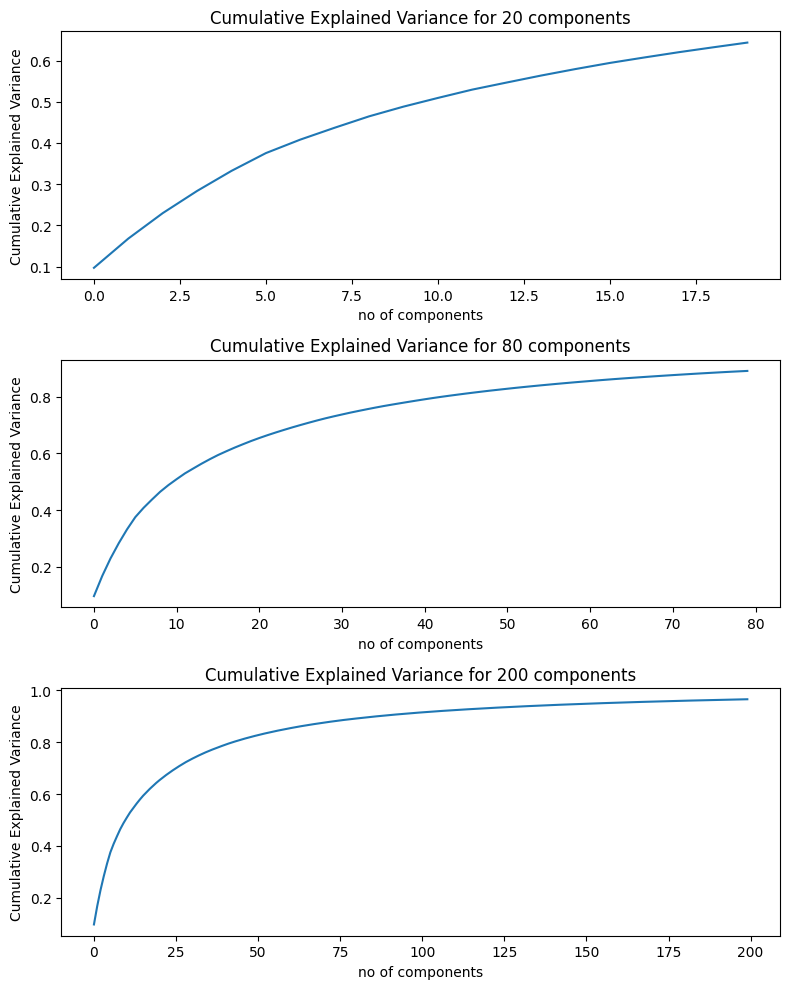

In [21]:
pca_200 = PCA(n_components=200, whiten=True).fit(train_X)
cumExplainedVar=np.cumsum(pca_200.explained_variance_ratio_)
fig, axes = plt.subplots(len(n_components_), 1, figsize=(8, 10))

for i in range(len(n_components_)):
  axes[i].plot(cumExplainedVar[:n_components_[i]])
  axes[i].set_title("Cumulative Explained Variance for " + str(n_components_[i]) + " components")
  axes[i].set_xlabel("no of components")
  axes[i].set_ylabel("Cumulative Explained Variance")
  
plt.tight_layout()
plt.show()

## Classification in different dimensions

In [22]:
SVM = svm.SVC(kernel=best_params['kernel'], C=best_params['C'])

fit_times = []
accuracies = []
for i in range(len(n_components_)):
  print(f'Classification in {n_components_[i]} dimensions')
  start_time = time.time()
  SVM.fit(train_components_[i], train_y)
  end_time = time.time()
  fit_time = end_time-start_time
  SVM_score = cross_validate(estimator=SVM, X=test_components_[i], y=test_y, scoring='accuracy', return_train_score=True, n_jobs=-1)

  fit_time_minutes = fit_time / 60
  fit_time_minutes = float("{:.2f}".format(fit_time_minutes))
  accuracy = float("{:.3f}".format(np.mean(SVM_score['test_score']*100)))
  print(f"Fit Time: {fit_time_minutes} minutes")
  print(f"Accuracy: {accuracy}\n")

  fit_times.append(fit_time_minutes)
  accuracies.append(accuracy)

Classification in 20 dimensions
Fit Time: 0.36 minutes
Accuracy: 96.06

Classification in 80 dimensions
Fit Time: 1.2 minutes
Accuracy: 96.86

Classification in 200 dimensions
Fit Time: 2.56 minutes
Accuracy: 96.74



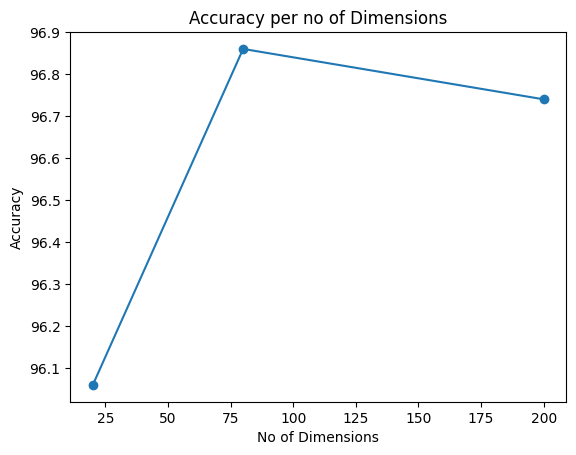

In [23]:
plt.plot(n_components_, accuracies, marker='o')
plt.xlabel('No of Dimensions')
plt.ylabel('Accuracy')
plt.title('Accuracy per no of Dimensions')
plt.show()

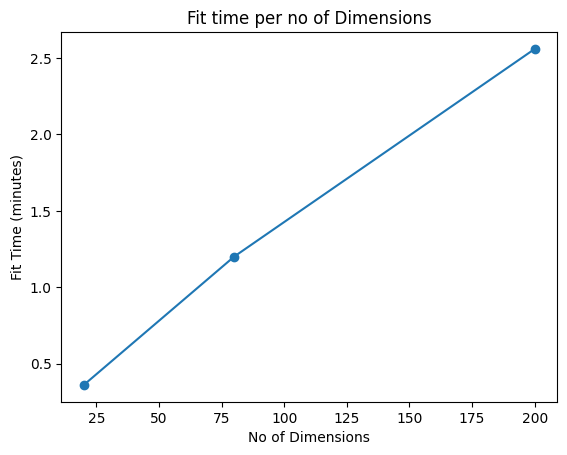

In [24]:
plt.plot(n_components_, fit_times, marker='o')
plt.xlabel('No of Dimensions')
plt.ylabel('Fit Time (minutes)')
plt.title('Fit time per no of Dimensions')
plt.show()

In [25]:
col_names = ['Dimensions'] + n_components_
preds = [['Accuracy'] + accuracies, ['Fit Time (minutes)'] + fit_times]
print(tabulate(preds, headers=col_names, tablefmt='fancy_grid'))

╒════════════════════╤═══════╤═══════╤═══════╕
│ Dimensions         │    20 │    80 │   200 │
╞════════════════════╪═══════╪═══════╪═══════╡
│ Accuracy           │ 96.06 │ 96.86 │ 96.74 │
├────────────────────┼───────┼───────┼───────┤
│ Fit Time (minutes) │  0.36 │  1.2  │  2.56 │
╘════════════════════╧═══════╧═══════╧═══════╛


We observe that as dimensions increase, accuracy and fit time increase. As for the accuracy in 200 dimensions it is slightly lower than that of 80 dimensions which indicates overfitting. By increasing dimensions we use more information that helps increase the accuracy of the model until a point, after which we have too much information and the model becomes more comlex than it should be and leads to decreasing accuracy in the test set. By reducing the dimensionality, the algorithm requires less computation, leading to faster runtime. However, dimensionality reduction results in information loss, which impacts accuracy. It is crucial to strike a balance among these factors finding the right trade-off.